## Project Introduction
For this clustering project, I'll be analyzing the geometrical properties of wheat kernels to classify them into their respective varieties. The goal is to explore and identify groupings within the data using unsupervised learning techniques. The dataset consists of measurements of kernels from three different varieties of wheat: Kama, Rosa, and Canadian.

### Algorithm
I'll be employing KMeans and Agglomerative Hierarchical Clustering to analyze the wheat kernel data. I'll start with KMeans first then I'll see if a hierarchical approach can provide better results. We'll see how well the clustering algorithm matches the labels.

### Motivation
The classification of wheat varieties based on geometric properties is important for agricultural research and industry. For example, for proper quality control, consistent and accurate classification ensures that only the desired wheat varieties are processed and distributed


### Dataset
I'll be using the "Seeds" dataset from the UCI Machine Learning Repository. This dataset includes measurements of seven geometric attributes of wheat kernels. The dataset contains 210 instances, with 70 kernels from each of the three varieties (Kama, Rosa, and Canadian)

https://archive.ics.uci.edu/dataset/236/seeds

Here is the mapping of the column names to the dataset description:

1. **A**: Area (A)
2. **P**: Perimeter (P)
3. **C**: Compactness (C = 4 * π * A / P²) which is how efficiently a shape occupies space, how much of a circle it is
4. **LK**: Length of Kernel
5. **WK**: Width of Kernel
6. **A_Coef**: Asymmetry Coefficient
7. **LKG**: Length of Kernel Groove
8. **target**: The variety of wheat (Kama, Rosa, Canadian) 0-2


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score, adjusted_mutual_info_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

file_path = 'Seed_Data.csv'
df = pd.read_csv(file_path)


## EDA

In [2]:
df.head()


,A,P,C,LK,WK,A_Coef,LKG,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       210 non-null    float64
 1   P       210 non-null    float64
 2   C       210 non-null    float64
 3   LK      210 non-null    float64
 4   WK      210 non-null    float64
 5   A_Coef  210 non-null    float64
 6   LKG     210 non-null    float64
 7   target  210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


Cool, there aren't any missing values and the data types don't haved to be modified.

In [16]:
duplicate_rows = df[df.duplicated()]
duplicate_rows.shape

(0, 8)

There aren't any duplicate rows

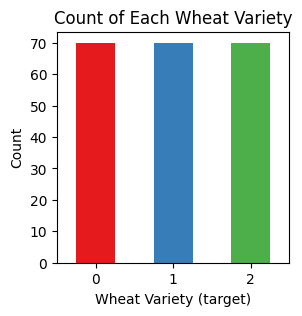

target
0    70
1    70
2    70
Name: count, dtype: int64

In [26]:
# Plot the count of each target category 
target_counts = df['target'].value_counts()

plt.figure(figsize=(3, 3))
target_counts.plot(kind='bar', color=sns.color_palette("Set1", len(target_counts)))
plt.title('Count of Each Wheat Variety')
plt.xlabel('Wheat Variety (target)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

target_counts


### Distribution of features

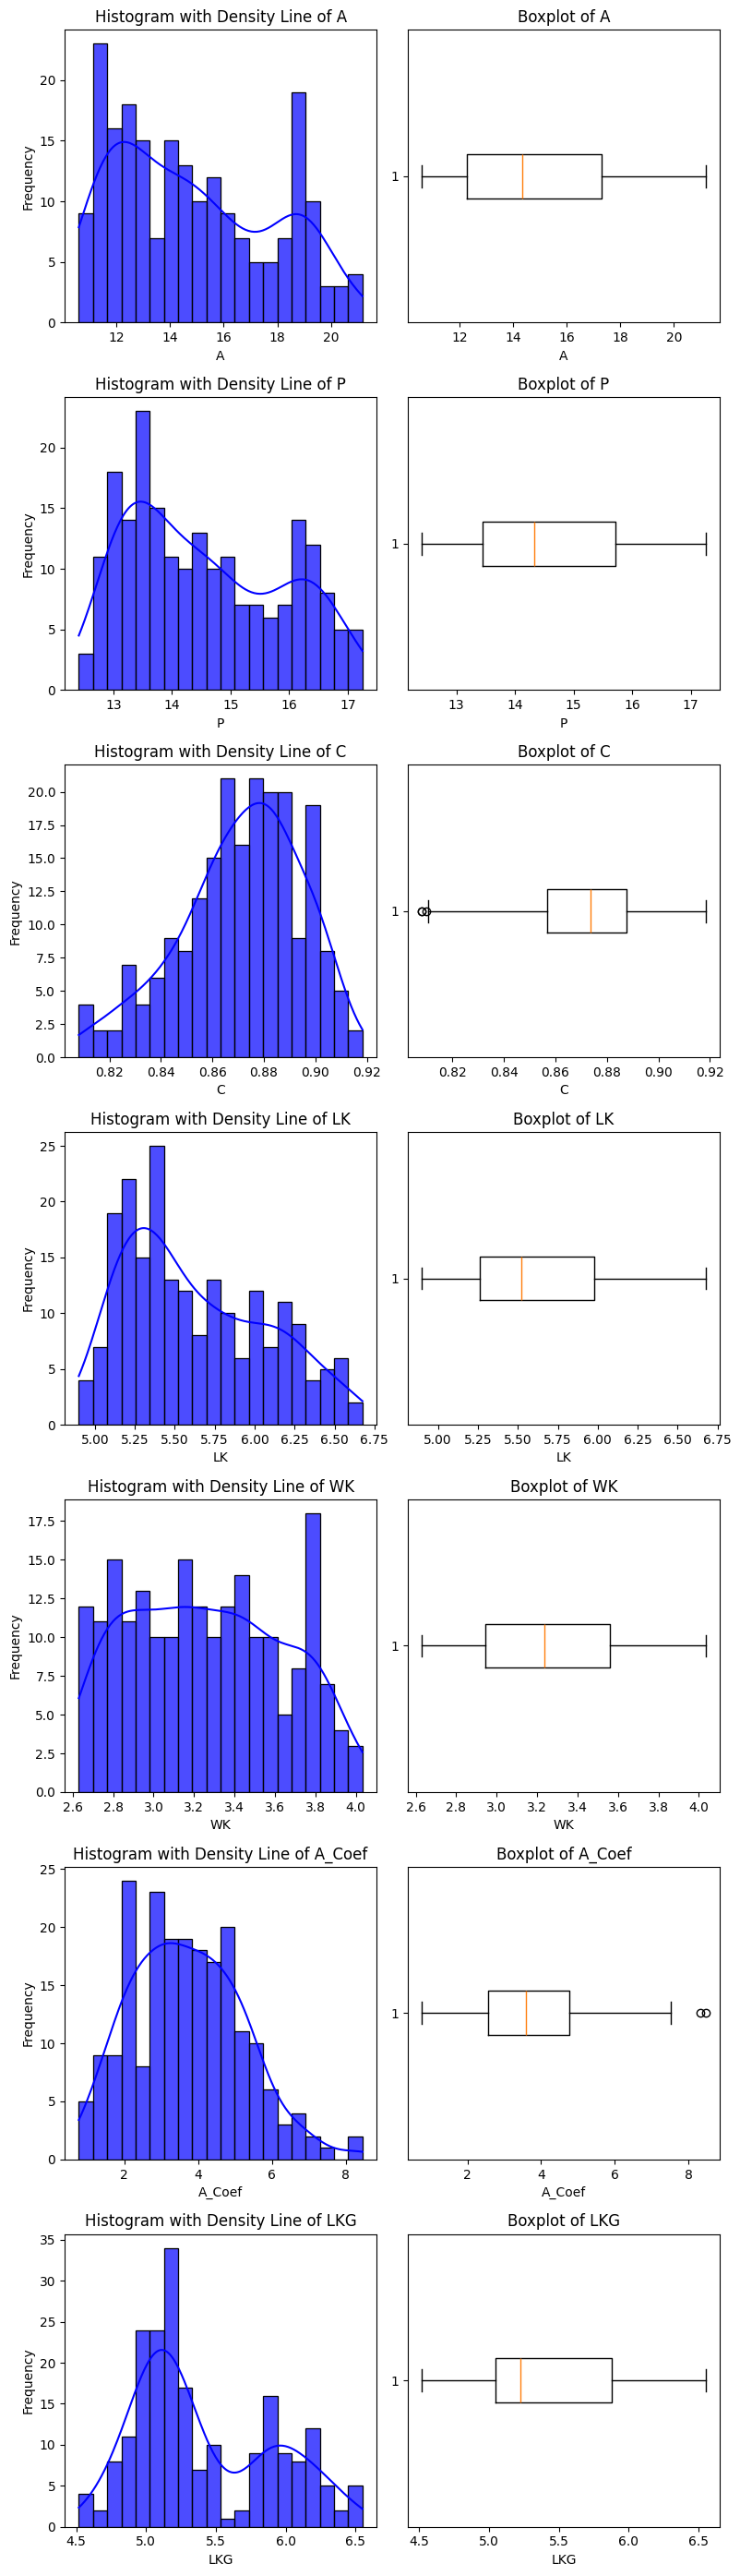

In [10]:
# Plotting histograms with density lines and box plots for each feature
features = df.columns[:-1]  # Exclude the target column

fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(8, len(features) * 4))

for i, feature in enumerate(features):
    # Histogram with density line
    sns.histplot(df[feature], bins=20, kde=True, ax=axes[i, 0], color='blue', alpha=0.7)
    axes[i, 0].set_title(f'Histogram with Density Line of {feature}')
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel('Frequency')
    
    # Boxplot
    axes[i, 1].boxplot(df[feature], vert=False)
    axes[i, 1].set_title(f'Boxplot of {feature}')
    axes[i, 1].set_xlabel(feature)

plt.tight_layout()
plt.show()


### Histograms:
- Most features exhibit slight right skewness (A, P, LK, A_Coef, LKG), with C being an exception with a pronounced left skew.
-  kewness across the features suggests mild deviations from normality, with C showing the most significant deviation.
- The WK feature shows a more complex distribution with multiple peaks and a less smooth density curve.

### Boxplots
- Most features are relatively symmetric, with C and A_Coef showing slight skewness.
- Mild outliers are present in C, A_Coef, and LKG, but they are not extreme.
- The IQRs are generally consistent, indicating a fairly uniform spread of the central data for most features.

### Checking for outliers

In [12]:
# Checking for outliers using the IQR method
Q1 = df[features].quantile(0.25)
Q3 = df[features].quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
outliers = ((df[features] < (Q1 - 1.5 * IQR)) | (df[features] > (Q3 + 1.5 * IQR)))

# Summing up the number of outliers per feature
outliers_sum = outliers.sum().sort_values(ascending=False)

missing_values = df.isnull().sum()

cleaning_df = pd.DataFrame({
    'Outliers': outliers_sum,
    'Missing Values': missing_values
})

cleaning_df.sort_values(by='Outliers', ascending=False)


,Outliers,Missing Values
C,3.0,0
A_Coef,2.0,0
A,0.0,0
LK,0.0,0
LKG,0.0,0
P,0.0,0
WK,0.0,0
target,NaN,0


There are only a few outliers. Only 3 for C and 2 for A_Coef. Generally, outliers should only be removed only if you can prove that it's wrong. 

### Correlation Matrix

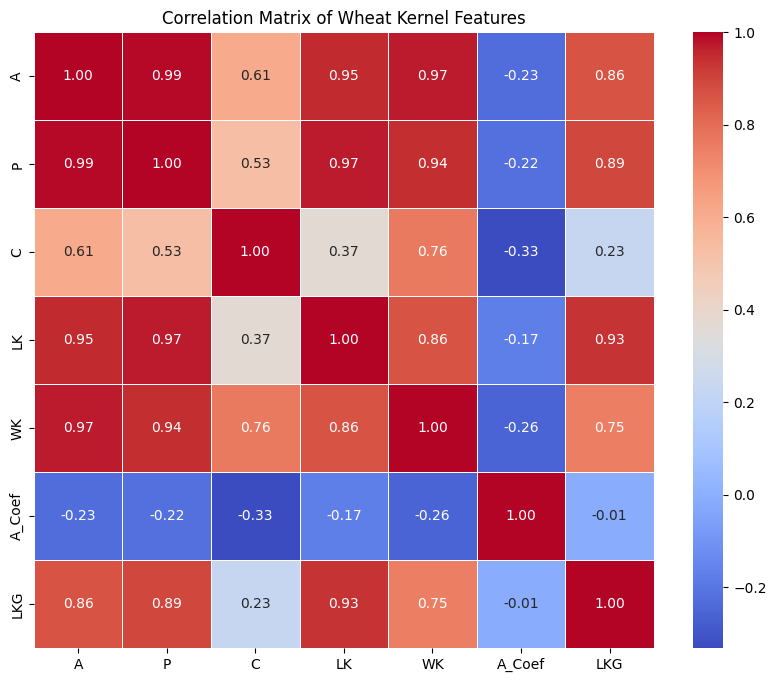

In [23]:
correlation_matrix = df.drop(columns=['target']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Wheat Kernel Features')
plt.show()

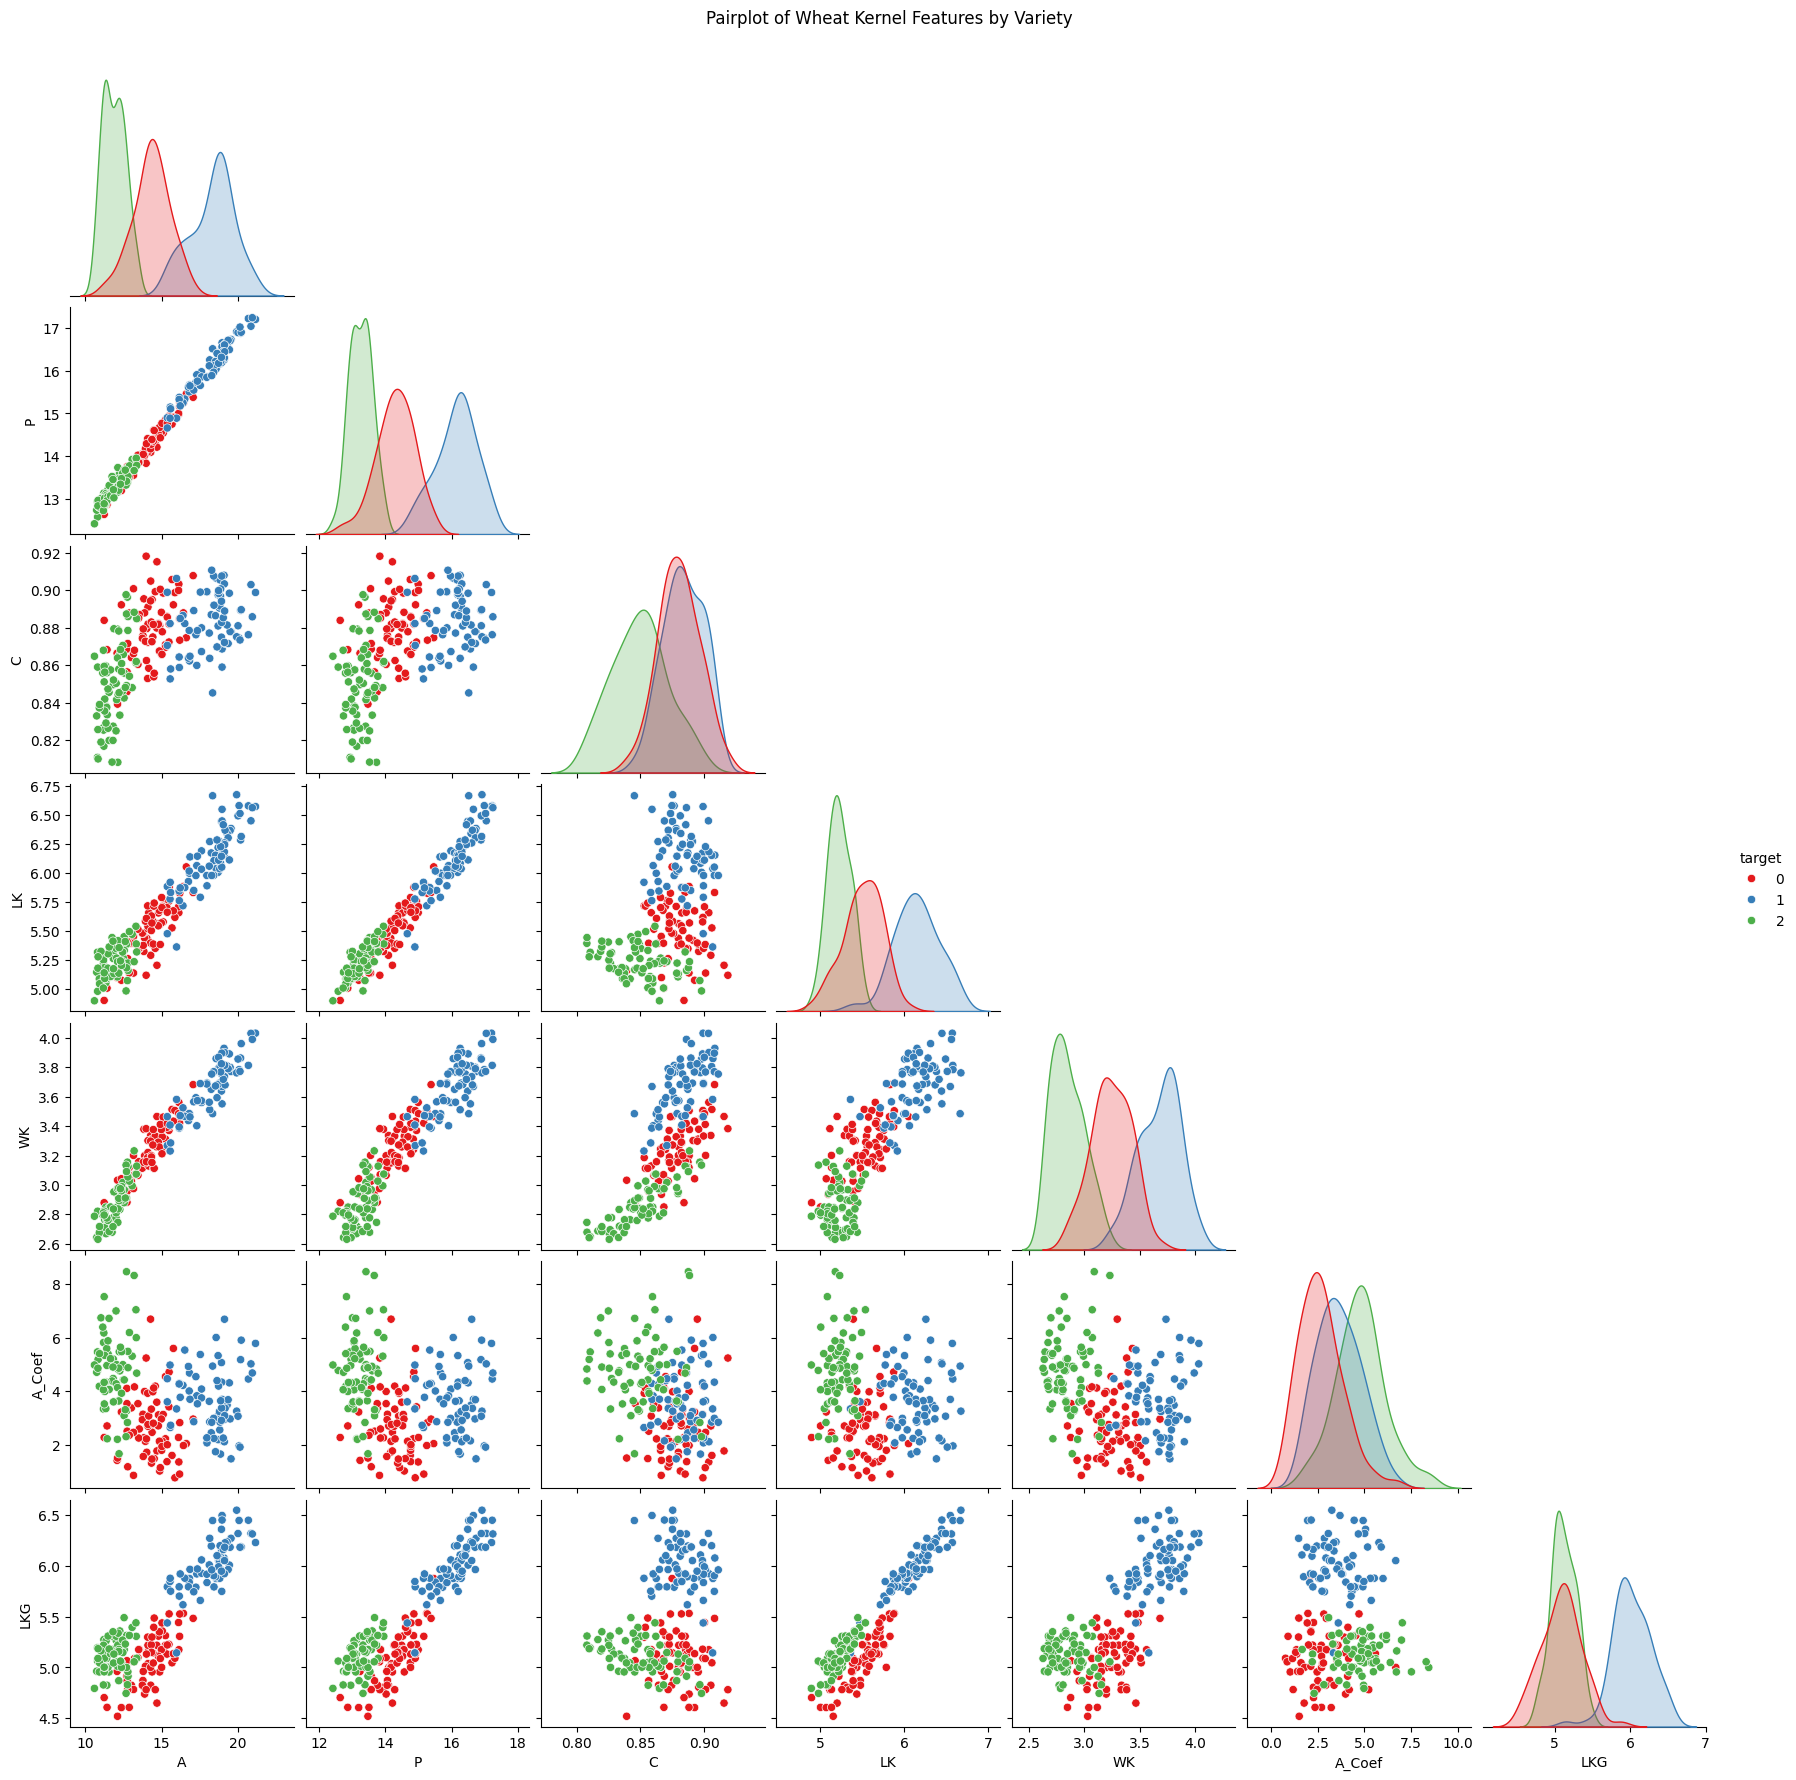

In [27]:
sns.pairplot(df, hue='target', palette='Set1', corner=True)
plt.suptitle('Pairplot of Wheat Kernel Features by Variety', y=1.02)
plt.show()


Most fetaures show evidence of sepearation between wheat varieties, but some, like LKG (Kernel Groove) and C (Compactness) shows overlap for for target 0 and 2, with a correlation matrix score of -0.33, which was the lowest score. C and A_coef also has a score of -0.33

## Model 1 - KMeans


### Introduction

For this analysis, we will explore the performance of KMeans clustering on a dataset, with a focus on determining the optimal number of Principal Component Analysis (PCA) components. The steps wil be:

1. **Data Preparation**: 
   - We start by separating the features and target variables and splitting the data into training and test sets.
   - We standardize the features to ensure that they are on the same scale, which is important for PCA and KMeans performance.

2. **PCA and KMeans Clustering**:
   - We apply PCA to reduce the dimensionality of the data and explore a range of PCA components. Since every feature can be a dimension, we will iterate through the range of features.
   - For each number of PCA components, we apply KMeans clustering to group the data into three clusters.

3. **Evaluation**:
   - The clustering performance is evaluated using two metrics: Adjusted Rand Index (AMI) and V-Measure.
   - We track the best results in terms of ARI and accuracy to identify the optimal number of PCA components.

4. **Model Refinement**:
   - After identifying the best number of PCA components, we refit KMeans using this optimal dimensionality and predict the clusters.


### Evalution Metrics 

#### ARI
The main metric that I'll be using is ARI, which is the standard for evaluting the performance of clustering algorithms when there are labels. It measures the similarity between two clustering results, taking into account the possibility of random assignments. ARI is designed to evaluate the agreement between the predicted clusters and **the true labels** in terms of pairwise assignments. The closer the score is to 1.0, the better it is.

The Wikipedia article about it provides a great explanation: https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index

#### V-measure
The main metric that I'll be using is the v-measure score. It's especially helpful when you want to assess the balance between homogeneity and completeness. V-measure calculates the harmonic mean of these two aspects:

- Homogeneity: This measures whether all the points in each cluster share the same true label. A cluster is perfectly homogeneous if all of its points belong to the same class.

- Completeness: This measures whether all the points that are members of a given class are also elements of the same cluster. A cluster is perfectly complete if it contains all elements of a single class.

The score ranges from 0 to 1, with a score closer to 1 indicating a better clustering result. It doesn't explicitly measure the direct agreement between predicted clusters and true labels in the same way ARI does, which is why I'll be using this as the secondary metric.

Paper: https://aclanthology.org/D07-1043.pdf

In [3]:

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [4]:
from sklearn.metrics import adjusted_rand_score, v_measure_score

# Define the range of PCA components to test
n_components_range = range(1, X.shape[1] + 1)

best_ari = -1
best_v_measure = -1
best_n_components = 0

ari_scores = []
v_measure_scores = []

for n_components in n_components_range:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    kmeans = KMeans(n_clusters=3, init='k-means++', n_init=50, max_iter=1000)
    kmeans.fit(X_pca)
    
    y_pred = kmeans.predict(X_pca)
    
    ari = adjusted_rand_score(y, y_pred)
    ari_scores.append(ari)
    
    v_measure = v_measure_score(y, y_pred)
    v_measure_scores.append(v_measure)
    
    # Track the best ARI and V-measure scores
    if ari > best_ari:
        best_ari = ari
        best_n_components = n_components
        
    if v_measure > best_v_measure:
        best_v_measure = v_measure

    best_y_pred = y_pred 

df['Predicted_Label'] = best_y_pred

Best number of PCA components: 2
Best ARI score: 0.7850359051341558
Best V-measure: 0.7384069651104697


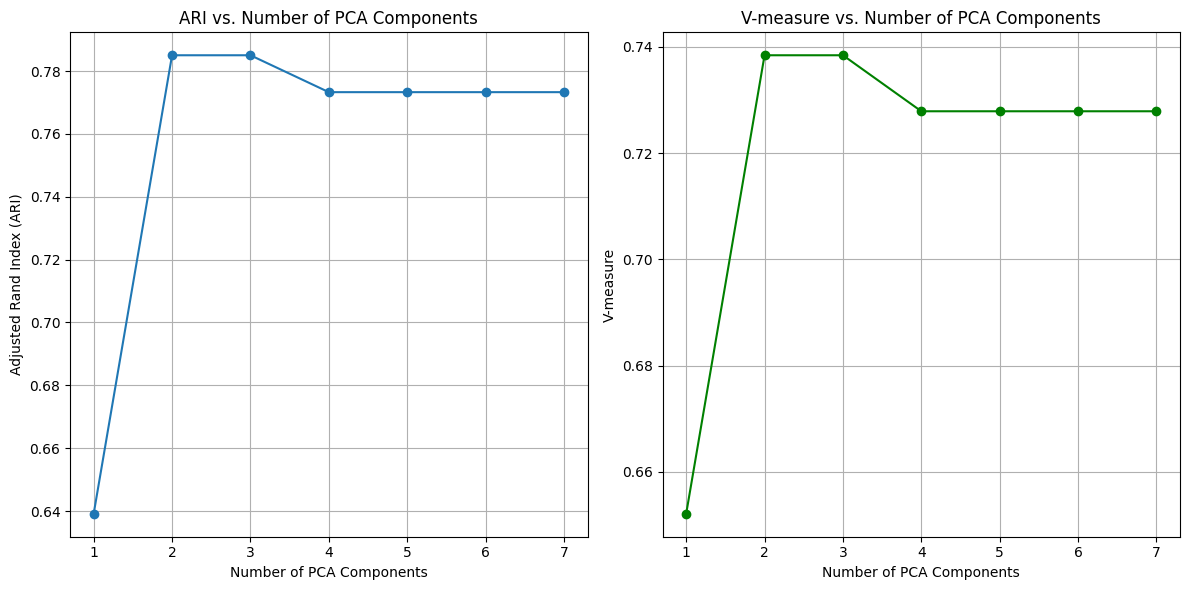

In [5]:
# Print the best number of PCA components, ARI, and V-measure
print(f'Best number of PCA components: {best_n_components}')
print(f'Best ARI score: {best_ari}')
print(f'Best V-measure: {best_v_measure}')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, ari_scores, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('ARI vs. Number of PCA Components')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(n_components_range, v_measure_scores, marker='o', color='green')
plt.xlabel('Number of PCA Components')
plt.ylabel('V-measure')
plt.title('V-measure vs. Number of PCA Components')
plt.grid(True)

plt.tight_layout()
plt.show()

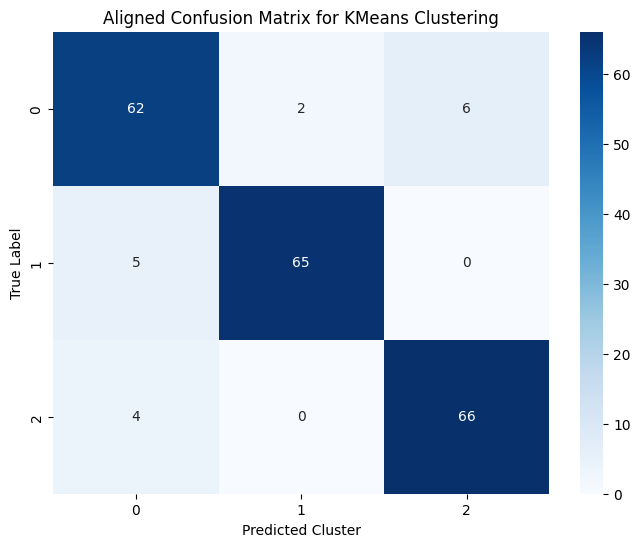

In [8]:
conf_mat_kmeans = confusion_matrix(y, df['Predicted_Label'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_kmeans, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(df['Predicted_Label']), yticklabels=np.unique(y))
plt.title('Confusion Matrix for KMeans Clustering')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.show()

In [7]:
print('Original Data Classes:')
print(df['target'].value_counts())
print('-' * 30)
print('Predicted Data Clusters:')
print(df['Predicted_Label'].value_counts())


Original Data Classes:
target
0    70
1    70
2    70
Name: count, dtype: int64
------------------------------
Predicted Data Clusters:
Predicted_Label
1    72
0    71
2    67
Name: count, dtype: int64


### **Summary** 

For the first model, we standardized the features so that PCA and KMeans will perform better, as they are both sensitive to the scale of data.
We iteratively tested the performance of KMeans with different PCA components. 
K-means++ is a smart initialization method that improves the chances of finding the optimal clusters by spreading out the initial centroids. We tried using 50 centroid seeds with 1000 iterations.

### **Result**
KMeans with two PCA components yieled the best results with an ARI score of 0.785, indicates a good level of agreement between the predicted cluster labels and the true labels. The score of 0.734 for v-measure is also good, but not ideal, as some clusters may be impure (containing data points from multiple classes) or that some classes may be split across multiple clusters.


## Model 2 - Agglomerative Hierarchical clustering

Agglomerative clustering is the most common type of hierarchical clustering using a bottom-up approach. It's good to also test with Agglomerative clustering because KMeans assumes that the clusters are spherical, while Agglomerative is effective when clusters have complex, non-spherical shapes

How It Works:
- Start with individual points: Initially, each data point is treated as its own cluster.
- Merge closest clusters: At each step, the algorithm merges the two clusters that are closest to each other (based on a specified distance metric).
- Repeat until one cluster remains: This process continues until all the points are merged into a single cluster, forming a hierarchy.

It'll be testing with different linkage criteria - ward, complete, and average linkage.
You can read about how they work here: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, v_measure_score, confusion_matrix
from sklearn.model_selection import ParameterGrid
from scipy.optimize import linear_sum_assignment

param_grid = {
    'n_clusters': [3],  
    'linkage': ['ward', 'complete', 'average'],
}

# Initialize a dictionary to store ARI and V-measure scores for each linkage
performance_scores = {}

# Iterate over each combination of parameters
for params in ParameterGrid(param_grid):
    # Apply Agglomerative Clustering with the current parameters
    agg_cluster = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage=params['linkage'])
    predicted_labels = agg_cluster.fit_predict(X_pca)
    
    # Calculate the ARI
    ari = adjusted_rand_score(y, predicted_labels)
    
    # Align cluster labels with true labels using the Hungarian algorithm
    conf_mat = confusion_matrix(y, predicted_labels)
    row_ind, col_ind = linear_sum_assignment(-conf_mat)
    label_mapping = {old_label: new_label for old_label, new_label in zip(col_ind, row_ind)}
    aligned_labels = pd.Series(predicted_labels).map(label_mapping)
    
    v_measure = v_measure_score(y, aligned_labels)
    
    performance_scores[params['linkage']] = {'ARI': ari, 'V-measure': v_measure}

performance_scores


{'ward': {'ARI': 0.7537938873813188, 'V-measure': 0.7130139979350258},
 'complete': {'ARI': 0.7860844701256925, 'V-measure': 0.7508825817840734},
 'average': {'ARI': 0.7757010404481931, 'V-measure': 0.7299861336521748}}

Best linkage method based on ARI: complete


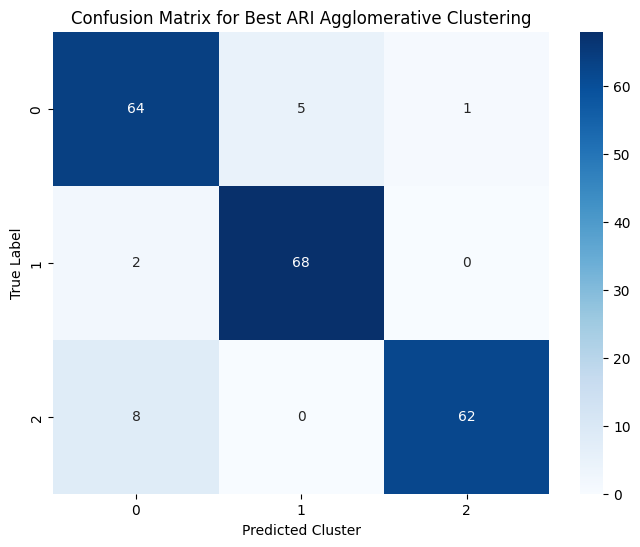

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Find the linkage method with the highest ARI
best_linkage = max(performance_scores, key=lambda k: performance_scores[k]['ARI'])
print(f'Best linkage method based on ARI: {best_linkage}')

# Apply Agglomerative Clustering with the best linkage method
best_agg_cluster = AgglomerativeClustering(n_clusters=3, linkage=best_linkage)
best_predicted_labels = best_agg_cluster.fit_predict(X_pca)

# Align cluster labels with true labels using the Hungarian algorithm
best_conf_mat = confusion_matrix(y, best_predicted_labels)
row_ind, col_ind = linear_sum_assignment(-best_conf_mat)
best_label_mapping = {old_label: new_label for old_label, new_label in zip(col_ind, row_ind)}
best_aligned_labels = pd.Series(best_predicted_labels).map(best_label_mapping)

conf_mat_best_ari = confusion_matrix(y, best_aligned_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_best_ari, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(best_aligned_labels), yticklabels=np.unique(y))
plt.title('Confusion Matrix for Best ARI Agglomerative Clustering')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.show()


In [27]:
df['Best_Predicted_Label'] = best_aligned_labels

# Display original and predicted class counts
print('Original Data Classes:')
print(df['target'].value_counts())
print('-' * 30)
print('Predicted Data Clusters:')
print(df['Best_Predicted_Label'].value_counts())


Original Data Classes:
target
0    70
1    70
2    70
Name: count, dtype: int64
------------------------------
Predicted Data Clusters:
Best_Predicted_Label
1    74
2    72
0    64
Name: count, dtype: int64


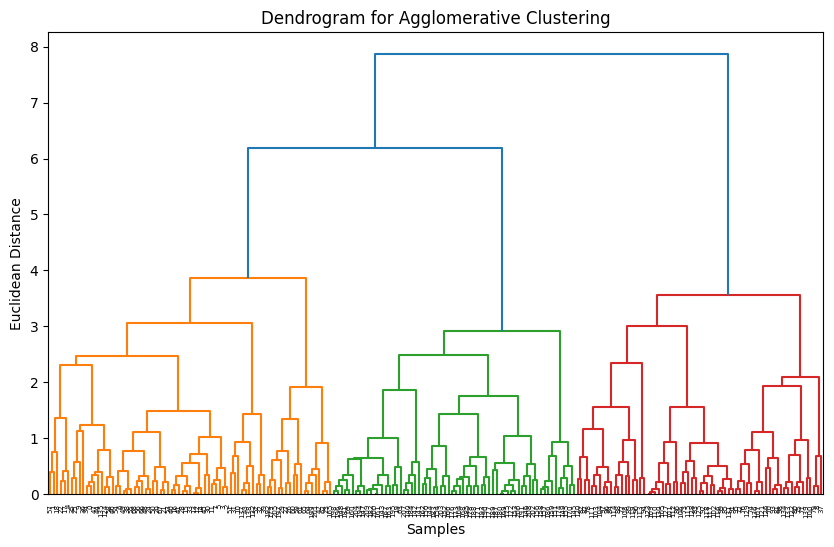

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X_pca, method='complete')  # Use the method from the best performing model
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Samples')
plt.ylabel('Euclidean Distance')
plt.show()

The dendrogram shows that there are sub-clusters within the main clusters, suggesting that further exploration could reveal additional structure. Also, the distinct separation between the three main clusters indicates that the clusters are well-defined and distinct from each other, which is a good sign for the clustering results.

## Results
| Clustering Method                     | ARI Score       | V-measure Score |
|---------------------------------------|-----------------|-----------------|
| **KMeans**                            | 0.7850          | 0.7384          |
| **Agglomerative Clustering (Complete Linkage)** | 0.7861          | 0.7509          |



### Learning and takeaway
In this project, I explored the effectiveness of two clustering algorithms—KMeans and Agglomerative Clustering—on the wheat kernel dataset. My primary objective was to evaluate how well these clustering methods could group the data into clusters that align with the true labels, representing different wheat varieties.

KMeans clustering produced respectable results, with a Best ARI score of 0.785 and a V-measure of 0.738. These metrics indicate that KMeans was quite effective in capturing the structure of the data and aligning the clusters with the true labels. However, the results were slightly surpassed by Agglomerative Clustering using Complete Linkage, which achieved an ARI score of 0.786 and a V-measure of 0.751. This suggests that the hierarchical approach of Agglomerative Clustering, particularly with complete linkage, might be slightly better suited for this dataset in terms of both cluster purity and completeness.



### Why Something Didn't Work
While the clustering methods used in this project—KMeans and Agglomerative Clustering—produced decent results, with ARI scores of 0.785 and 0.786 respectively, there were limitations that prevented these models from achieving even higher performance.

A challenge with these clustering methods is that they assume clusters are spherical or equally spread in the feature space. KMeans assumes that the data points in each cluster are centered around a centroid and that the clusters are roughly equal in size and shape. This assumption can be problematic when data produces clusters that may be elongated, irregularly shaped, or of unequal size. As a result, KMeans may misassign data points that don't fit neatly into the assumed spherical clusters, leading to suboptimal results

Similarly, Agglomerative Clustering with Complete Linkage tends to form clusters based on the maximum distance between points in different clusters, which can lead to chaining effects—where clusters form by connecting individual points or small groups of points that are far apart. This can result in clusters that don't necessarily reflect the natural groupings in the data, particularly when the data has noise or outliers. The slightly better performance of Agglomerative Clustering might indicate that it handles the data distribution somewhat better than KMeans, but it still suffers from these inherent limitations.

### How to improve
To improve clustering, consider advanced feature engineering, non-spherical algorithms like DBSCAN, and alternative dimensionality reductions like t-SNE. Also, ensemble techniques, where you combine multiple methods may produce better results as well.